In [10]:
from dapnn.imports import *
from dapnn.data_processing import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import pandas as pd
import pm4py
import tqdm

import warnings
warnings.filterwarnings(action='once')

In [5]:
# Set the random seed for reproducible results
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything()

In [7]:
def get_process_model(log, model_str):
    if model_str == 'IM':
        net, im, fm = pm4py.discover_petri_net_inductive(log)
    elif model_str == 'alpha':
        net, im, fm = pm4py.discover_petri_net_alpha(log)
    elif model_str == 'heuristic':
        net, im, fm = pm4py.discover_petri_net_heuristics(log)
    return net, im, fm

In [6]:
log_path='data/csv/PDC2020_training/'
log = import_log(log_path)

num_traces = len(log['trace_id'].unique())
ratio = 0.2
traces_for_process_model = int(num_traces * ratio)

['data/csv/PDC2020_training/pdc_2020_0000000.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0000001.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0000010.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0000011.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0000100.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0000101.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0000110.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0000111.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001000.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001001.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001010.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001011.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001100.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001101.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001110.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0001111.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0010000.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0010001.csv.gz', 'data/csv/PDC2020_training/pdc_2020_0010010.c

In [8]:
test_path = 'data/csv/PDC2020_ground_truth/'
test_log = import_log(test_path)

df = test_log.copy()
df = df[['trace_id', 'normal']]
df = df.drop_duplicates()

test_log = pm4py.format_dataframe(test_log, case_id='trace_id', activity_key='activity', timestamp_key='event_id')
test_log = pm4py.convert_to_event_log(test_log)

['data/csv/PDC2020_ground_truth/pdc_2020_0000000.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0000001.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0000010.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0000011.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0000100.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0000101.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0000110.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0000111.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001000.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001001.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001010.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001011.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001100.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001101.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001110.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0001111.csv.gz', 'data/csv/PDC2020_ground_truth/pdc_2020_0010000.csv.gz', 'data/csv/PDC2020_ground_truth

/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

In [16]:
from tqdm.notebook import tqdm_notebook

In [38]:
def calc_precision(df, col='combined'):
    tp = df[(df[col] == True) & (df['y_true'] == True)].shape[0]
    fp = df[(df[col] == True) & (df['y_true'] == False)].shape[0]
    return tp / (tp + fp) if tp + fp > 0 else 0

def calc_recall(df, col='combined'):
    tp = df[(df[col] == True) & (df['y_true'] == True)].shape[0]
    fn = df[(df[col] == False) & (df['y_true'] == True)].shape[0]
    return tp / (tp + fn) if tp + fn > 0 else 0

def calc_f1(r, p):
    return 2 * ((p * r) / (p + r)) if p + r > 0 else 0

In [27]:
def calc_preformance(nn_model, process_model, rule=1):
    merged_df = nn_model.copy()
    merged_df.columns = ['nn_y_pred', 'y_true']
    merged_df['process_y_pred'] = process_model['y_pred']
    print('=' * 20)
    if rule == 0:
        print('Only using process model')
        rule = 'Only Process'
        merged_df['combined'] = merged_df['process_y_pred']
    elif rule == 1:
        print('Using OR rule')
        rule = 'OR'
        merged_df['combined'] = merged_df['nn_y_pred'] | merged_df['process_y_pred']
    elif rule == 2:
        print('Using AND rule')
        rule = 'AND'
        merged_df['combined'] = merged_df['nn_y_pred'] & merged_df['process_y_pred']
    elif rule == 3:
        print('Using XOR rule')
        rule = 'XOR'
        merged_df['combined'] = merged_df['nn_y_pred'] ^ merged_df['process_y_pred']
    else:
        raise ValueError('rule must be 1, 2, or 3')

    p = calc_precision(merged_df)
    r = calc_recall(merged_df)
    f1 = calc_f1(r, p)

    dict_measures = {'rule': rule, 'recall': r,'precision': p, 'f1': f1}
    
    return dict_measures

In [31]:
def replay_log_measures(log, net, im, fm ,df, dapnn):
    replayed_log = pm4py.conformance_diagnostics_token_based_replay(log, net, im, fm)
    predicted = dict()
    for i, trace in enumerate(replayed_log):
        predicted[f'trace {i+1}'] = not trace['trace_is_fit'] # the trace is anomalous if it is not fit
    predicted = pd.DataFrame.from_dict(predicted, orient='index', columns=['predicted'])
    predicted.index.name = 'trace_id'
    predicted = predicted.join(df, on='trace_id')[['predicted', 'normal']]
    predicted['normal'].replace({True: False, False: True}, inplace=True)
    predicted.columns = ['y_pred', 'y_true']
    
    list_dicts = []
    for rule in range(4):
        dict_measures = calc_preformance(dapnn, predicted, rule=rule)
        list_dicts.append(dict_measures)
       
    return list_dicts

In [32]:
def sample_processes(model_str, log, traces_for_process_model, test_log, dapnn, iterations=10):
    big_list = []

    for i in tqdm_notebook(range(iterations), desc=f'Running {iterations} iterations'):
        sampled_traces = random.sample(list(log['trace_id'].unique()), traces_for_process_model)
        
        sampled_log = log[log['trace_id'].isin(sampled_traces)].copy()
        sampled_log = pm4py.format_dataframe(sampled_log, case_id='trace_id', activity_key='activity', timestamp_key='event_id')
        sampled_log = pm4py.convert_to_event_log(sampled_log)

        net, im, fm = get_process_model(sampled_log, model_str)
        list_dicts = replay_log_measures(test_log, net, im, fm, df, dapnn)
        big_list.extend(list_dicts)
        
        del net, im, fm, sampled_traces, sampled_log
    
    return big_list

In [43]:
dapnn = pd.read_csv('all_model/dapnn_y_pred_y_true.csv')

In [39]:
big_list = sample_processes('IM', log, traces_for_process_model, test_log, dapnn, iterations=10)

/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


Running 10 iterations:   0%|          | 0/10 [00:00<?, ?it/s]

/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/lv_local/home/romh/PROGS/anaconda3/envs/dapnn/lib/python3.9/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

replaying log with TBR, completed variants ::   0%|          | 0/78736 [00:00<?, ?it/s]

Only using process model
Using OR rule
Using AND rule
Using XOR rule


In [40]:
big_df = pd.DataFrame(big_list)
only_process_df = big_df[big_df['rule'] == 'Only Process']
or_df = big_df[big_df['rule'] == 'OR']
and_df = big_df[big_df['rule'] == 'AND']
xor_df = big_df[big_df['rule'] == 'XOR']

In [41]:
def plot_measures(df, model_str='IM'):
    recall = df['recall']
    precision = df['precision']
    f1 = df['f1']
    rule = df['rule'].iloc[0]

    plt.figure(figsize=(10, 5))
    plt.title(f'{model_str}({rule})')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.plot(recall, label='recall')
    plt.plot(precision, label='precision')
    plt.plot(f1, label='f1')
    plt.legend()
    plt.show()

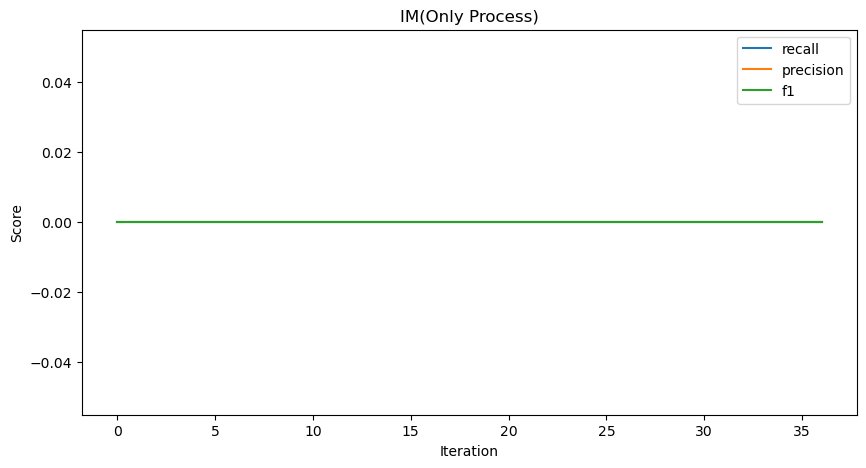

In [42]:
plot_measures(only_process_df)